# Image to Image Retrieval using CLIP embedding and image correlation reasoning using GPT4V

Author:Claudia Magliano

Date: 13/07/2024


In this notebook, we build a Image to Image retrieval using LlamaIndex with GPT4-V and CLIP.

LlamaIndex Image to Image Retrieval

Images embedding index: CLIP embeddings from OpenAI for images
Framework: LlamaIndex

Steps:

1)Download texts, images, pdf raw files from Wikipedia pages

2)Build Multi-Modal index and vetor store for both texts and images

3)Retrieve relevant images given a image query using Multi-Modal Retriever

4)Using GPT4V for reasoning the correlations between the input image and retrieved images

In [1]:
!pip install llama-index-multi-modal-llms-openai
!pip install llama-index-vector-stores-qdrant

In [2]:
!pip install llama_index ftfy regex tqdm
!%pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!%pip install matplotlib scikit-image
!pip install -U qdrant_client

/bin/bash: line 1: fg: no job control
/bin/bash: line 1: fg: no job control


In [3]:
import os

OPENAI_API_KEY = "sk-"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

Download images and texts from Wikipedia

In [4]:
!pip install wikipedia

In [5]:
import wikipedia
import urllib.request
from pathlib import Path


image_path = Path("mixed_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Vincent van Gogh",
    "Leonardo da Vinci",
    "Rembrandt",
    "Francisco Goya",
    "Pierre-Auguste Renoir",
    "Sandro Botticelli",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]


                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )

                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

Vincent van Gogh
Vincent van Gogh_Cuesmes_JPG001.jpg
mixed_wiki
Vincent van Gogh_De_zaaier_-_s0029V1962_-_Van_Gogh_Museum.jpg
mixed_wiki
Vincent van Gogh_Felix_Rey_portrait_%26_sketch.jpg
mixed_wiki
Vincent van Gogh_Graves_of_Vincent_and_Th%C3%A9odore_Van_Gogh.jpg
mixed_wiki
Vincent van Gogh_Jo_van_Gogh-Bonger%2C_by_Woodbury_and_Page-2.jpg
mixed_wiki
Vincent van Gogh_Kee_Vos_met_zoon_Jan-cropped.jpg
mixed_wiki
Vincent van Gogh_Landscape_with_Wheat_Sheaves_and_Rising_Moon_%28F735%29.jpg
mixed_wiki
Vincent van Gogh_Le_Forum_R%C3%A9publicain_%28Arles%29_-_30_December_1888_-_Vincent_van_Gogh_ear_incident.jpg
mixed_wiki
Vincent van Gogh_Paul_Gauguin_-_Vincent_van_Gogh_painting_sunflowers_-_Google_Art_Project.jpg
mixed_wiki
Vincent van Gogh_Red_vineyards.jpg
mixed_wiki
Vincent van Gogh_Self-Portrait_%28Van_Gogh_September_1889%29.jpg
mixed_wiki
Vincent van Gogh_Stilleven_met_bijbel_-_s0008V1962_-_Van_Gogh_Museum.jpg
mixed_wiki
Vincent van Gogh_Theo_van_Gogh_May_1878_%28restored%29.jpg
mixed_w

Plot images from Wikipedia

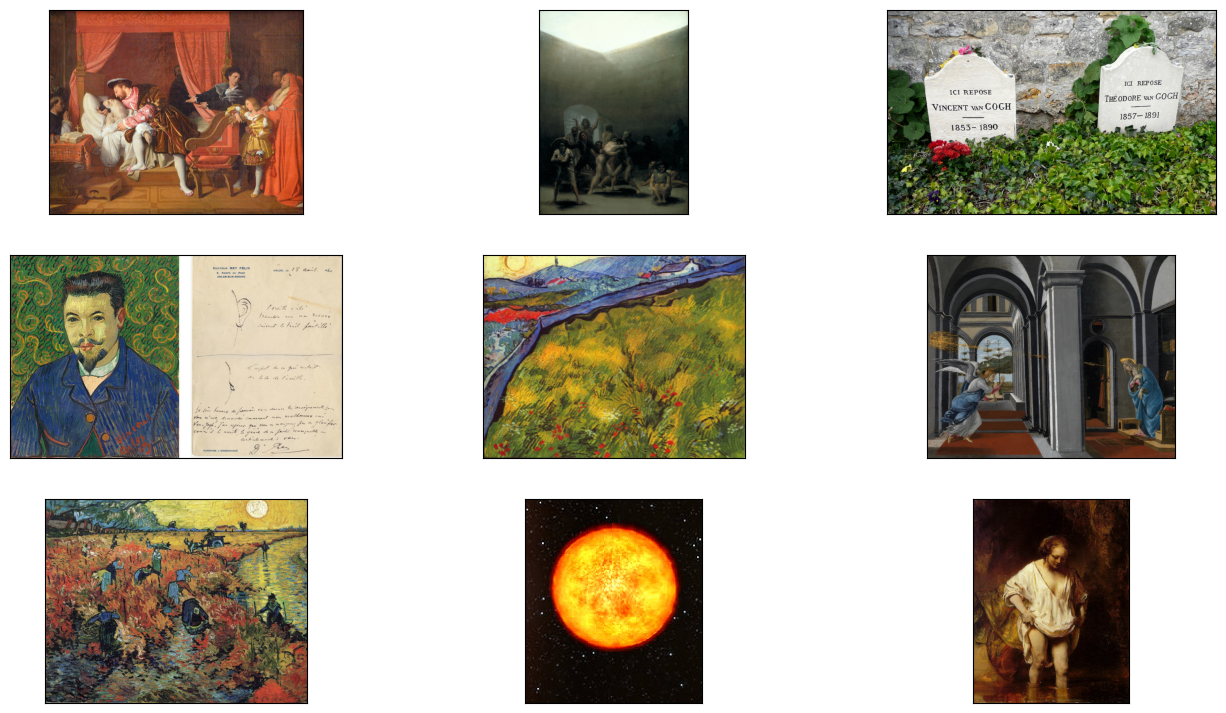

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./mixed_wiki"):
    image_paths.append(str(os.path.join("./mixed_wiki", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

Build Multi-Modal index and Vector Store to index both text and images from Wikipedia

In [7]:
!pip install llama-index-embeddings-clip
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hdprzqau
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hdprzqau
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [8]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_img_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

Plot input query image

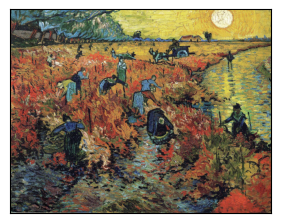

In [19]:
input_image = "./mixed_wiki/10.jpg"
plot_images([input_image])

Retrieve images from Multi-Modal Index given the image query

1. Image to Image Retrieval Results

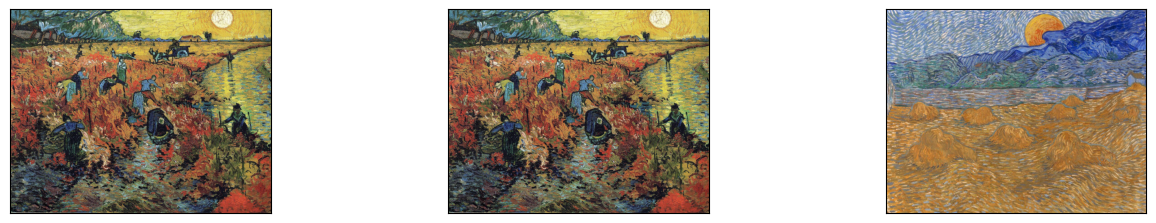

In [21]:
# generate Text retrieval results
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.image_to_image_retrieve(
    "./mixed_wiki/10.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

# Remove the first retrieved image as it is the input image
# since the input image will gethe highest similarity score
plot_images(retrieved_images[1:])

2. GPT4V Reasoning Retrieved Images based on Input Image

In [22]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader
from llama_index.core.schema import ImageDocument

# put your local directore here
image_documents = [ImageDocument(image_path=input_image)]

for res_img in retrieved_images[1:]:
    image_documents.append(ImageDocument(image_path=res_img))


openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)
response = openai_mm_llm.complete(
    prompt="Given the first image as the base image, what the other images correspond to?",
    image_documents=image_documents,
)

print(response)

The first three images are identical and depict "The Red Vineyard" by Vincent van Gogh. The fourth image is different and depicts "Wheat Field with Cypresses," also by Vincent van Gogh. Both paintings are well-known works by the artist, showcasing his distinctive style and use of color.


Using Image Query Engine
Inside Query Engine, there are few steps:

1)Retrieve relevant images based on input image

2)Compose the `image_qa_template`` by using the promt text

3)Sending top k retrieved images and image_qa_template for GPT4V to answer/synthesis

In [24]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import PromptTemplate


qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)


openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, image_qa_template=qa_tmpl
)

query_str = "Tell me more about the relationship between those paintings. "
response = query_engine.image_query("./mixed_wiki/10.jpg", query_str)

In [13]:
print(response)

It appears that the images provided are identical. They both depict the same painting, which is "The Sower" by Vincent van Gogh. This painting is known for its vibrant use of color and dynamic composition, featuring a sower scattering seeds in a field with a large, radiant sun in the background.

Since the images are the same, there is no additional relationship to discuss between them beyond the fact that they are duplicates of the same artwork.
